In [1]:
from eelbrain import *
import glob
import mne
import numpy as np

In [2]:
# configure(n_workers=False)

In [3]:
def get_files(subjs, exclude):
    
    for i in range(len(exclude)):
        exclude[i] = f'./analysis\\Rise00{exclude[i]}-epo.fif'
    
    subjs = list(set(subjs) - set(exclude))
    
    return subjs

epoch_files = glob.glob('./analysis/Rise*-epo.fif')

subjs_all = get_files(epoch_files, exclude=[])
subjs_excl = get_files(epoch_files, exclude=['2', '3', '22', '25', '33', '34', '36'])

In [4]:
conds_to_compare = ['Rise', 'Fall']

In [5]:
ds = Dataset()
event_dict = {
                # '1002': 'Neutral', 
                '1003': 'Rise',
                '1004': 'Fall'
            }

rows = []
for subj in subjs_all:
    for key, val in event_dict.items():
        subject = int(subj[17: 19])
        condition = val
        eeg = load.fiff.epochs_ndvar(mne.read_epochs(subj, verbose=False)[key], data='eeg')
        rows.append([subject, condition, eeg.mean('case')])

ds = Dataset.from_caselist(['subject', 'condition', 'eeg'], rows)
ds['subject'].random = True
print(ds.summary())

Key         Type     Values                                        
-------------------------------------------------------------------
subject     Var      1 - 38                                        
condition   Factor   Fall:24, Rise:24                              
eeg         NDVar    64 sensor, 701 time; -2.9253e-05 - 3.53993e-05
-------------------------------------------------------------------
Dataset: 48 cases


In [6]:
# ds.save()

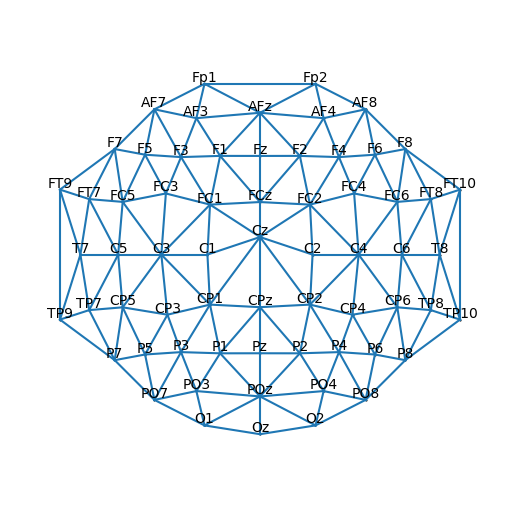

In [7]:
p = plot.SensorMap(ds['eeg'], connectivity=True)

In [8]:
res = testnd.TTestRelated(
    'eeg', 'condition', conds_to_compare[0], conds_to_compare[1], match='subject', ds=ds,
    pmin=0.05,  # Use uncorrected p = 0.05 as threshold for forming clusters
    tstart=0.100,  # Find clusters in the time window from 100 ...
    tstop=0.600,  # ... to 600 ms
    # mintime=0.1,
    # minsource=2
)

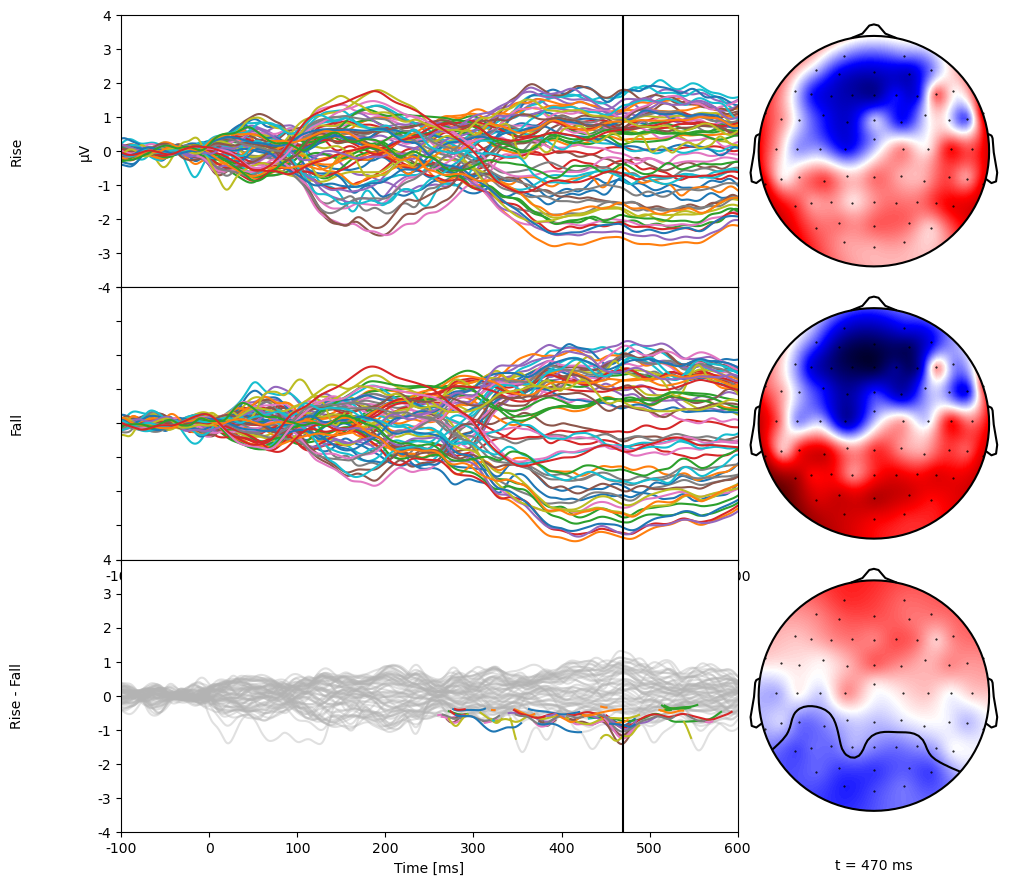

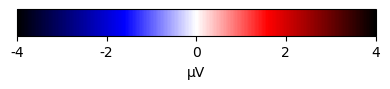

In [9]:
p = plot.TopoButterfly(res, clip='circle')
p.plot_colorbar()
p.set_time(0.470)

In [10]:
clusters = res.find_clusters(0.05)
print(clusters)

id    n_sensors   tstart   tstop   duration   v         p        sig
--------------------------------------------------------------------
100   23          0.26     0.594   0.334      -5782.9   0.0308   *  


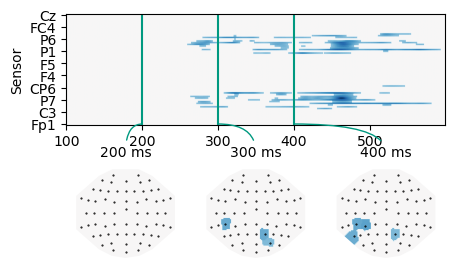

In [11]:
a = clusters['id'][:]

cluster_ndvars = []

for i in range(len(a)):
    cluster = res.cluster(a[i])
    cluster_ndvars.append(cluster)
    p = plot.TopoArray(cluster, interpolation='nearest')
    p.set_topo_ts(0.2, 0.3, 0.4)

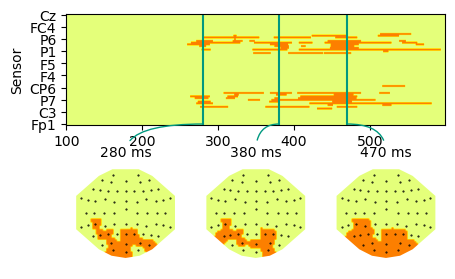

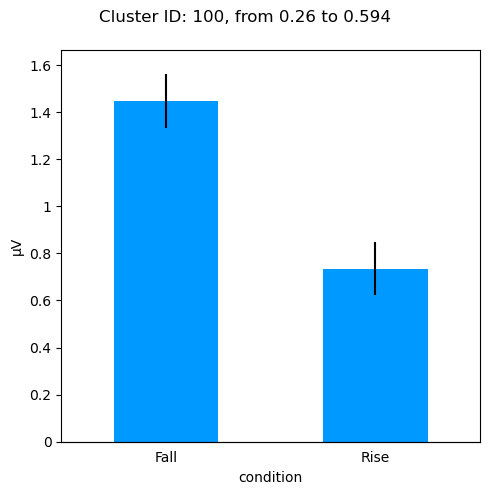

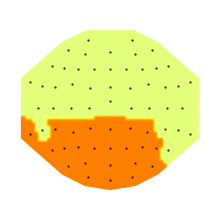

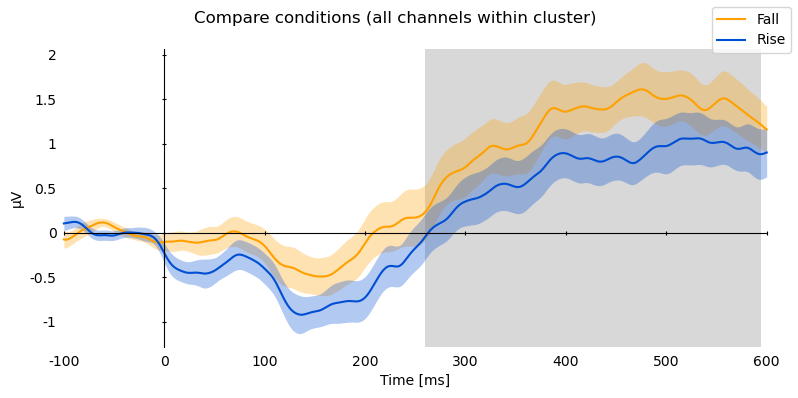

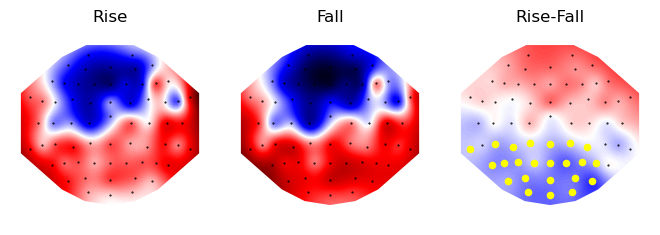

In [12]:
masks = []

for i in range(len(cluster_ndvars)):

    # sensor x sample plot with topogrpahy
    mask = cluster_ndvars[i] != 0
    masks.append(mask)
    p = plot.TopoArray(mask, cmap='Wistia')
    p.set_topo_ts(.280, 0.380, 0.470)

    # barplot for magnitude of each condition within a cluster
    ds['cluster_mean'] = ds['eeg'].mean(mask)
    p = plot.Barplot('cluster_mean', 'condition', match='subject', ds=ds, test=False, title=f'Cluster ID: {clusters[i, "id"]}, from {clusters[i, "tstart"]} to {clusters[i, "tstop"]}')

    # topography map for spatial extent of each cluster
    roi = mask.any('time')
    p = plot.Topomap(roi, cmap='Wistia')

    
    ds['cluster_timecourse'] = ds['eeg'].mean(roi)
    p = plot.UTSStat('cluster_timecourse', 'condition', match='subject', ds=ds, frame='t', title='Compare conditions (all channels within cluster)')
    # mark the duration of the spatio-temporal cluster
    p.set_clusters(clusters[[i]])

    # mark significant sensors in topographic map of difference between conditions
    time_window = (clusters[0, 'tstart'], clusters[0, 'tstop'])
    c1_topo = res.c1_mean.mean(time=time_window)
    c0_topo = res.c0_mean.mean(time=time_window)
    diff_topo = res.difference.mean(time=time_window)
    p = plot.Topomap([c1_topo, c0_topo, diff_topo], axtitle=[conds_to_compare[0], conds_to_compare[1], f'{conds_to_compare[0]}-{conds_to_compare[1]}'], ncol=3)
    p.mark_sensors(roi, -1)

#### Temporal cluster-based test

id   tstart   tstop   duration   v         p        sig
-------------------------------------------------------
3    0.421    0.582   0.161      -481.26   0.0026   ** 


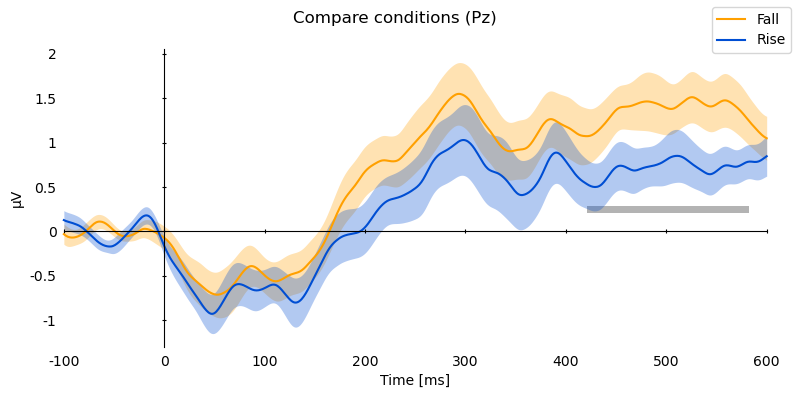

In [13]:
ds['eeg_pz'] = ds['eeg'].sub(sensor='Pz')

res_timecoure = testnd.TTestRelated(
    'eeg_pz', 'condition', conds_to_compare[0], conds_to_compare[1], match='subject', ds=ds,
    pmin=0.05,  # Use uncorrected p = 0.05 as threshold for forming clusters
    tstart=0.100,  # Find clusters in the time window from 100 ...
    tstop=0.600,  # ... to 600 ms
    mintime=0.1
)
clusters_pz = res_timecoure.find_clusters(0.05)
print(clusters_pz)

p = plot.UTSStat('eeg_pz', 'condition', match='subject', ds=ds, frame='t', title='Compare conditions (Pz)')
p.set_clusters(clusters_pz, y=0.25e-6)

id   tstart   tstop   duration   v   p   sig
--------------------------------------------


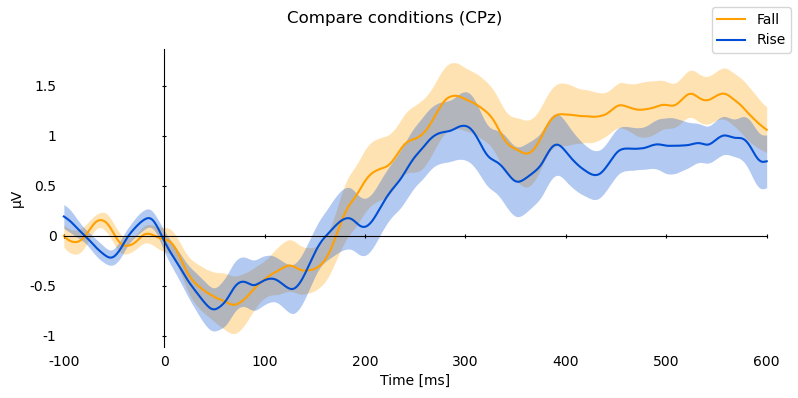

In [14]:
ds['eeg_cpz'] = ds['eeg'].sub(sensor='CPz')

res_timecoure = testnd.TTestRelated(
    'eeg_cpz', 'condition', conds_to_compare[0], conds_to_compare[1], match='subject', ds=ds,
    pmin=0.05,  # Use uncorrected p = 0.05 as threshold for forming clusters
    tstart=0.100,  # Find clusters in the time window from 100 ...
    tstop=0.600,  # ... to 600 ms
    mintime=0.1
)
clusters_cpz = res_timecoure.find_clusters(0.05)
print(clusters_cpz)

p = plot.UTSStat('eeg_cpz', 'condition', match='subject', ds=ds, frame='t', title='Compare conditions (CPz)')
p.set_clusters(clusters_cpz, y=0.25e-6)